In [1]:
from utils import *
import time
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from stock_reader import reader
import sklearn.preprocessing
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False
import warnings
import seaborn as sns
sns.set()

In [2]:
warnings.filterwarnings("ignore")

Enter Code or Symbol :  005930
Enter date(YYYY-MM--DD) :  2010



     Symbol  Name          Sector
941  005930  삼성전자  통신 및 방송 장비 제조업

             open   high    low  close    volume    change
Date                                                      
2010-01-04  16060  16180  16000  16180    239271  0.012516
2010-01-05  16520  16580  16300  16440    559219  0.016069
2010-01-06  16580  16820  16520  16820    459755  0.023114
2010-01-07  16820  16820  16260  16260    443237 -0.033294
2010-01-08  16400  16420  16120  16420    295798  0.009840
...           ...    ...    ...    ...       ...       ...
2020-01-23  61800  61800  60700  60800  14916555 -0.024077
2020-01-28  59400  59400  58300  58800  23664541 -0.032895
2020-01-29  59100  59700  58800  59100  16446102  0.005102
2020-01-30  58800  58800  56800  57200  20821939 -0.032149
2020-01-31  57800  58000  57300  57600   3801732  0.006993

[2483 rows x 6 columns]


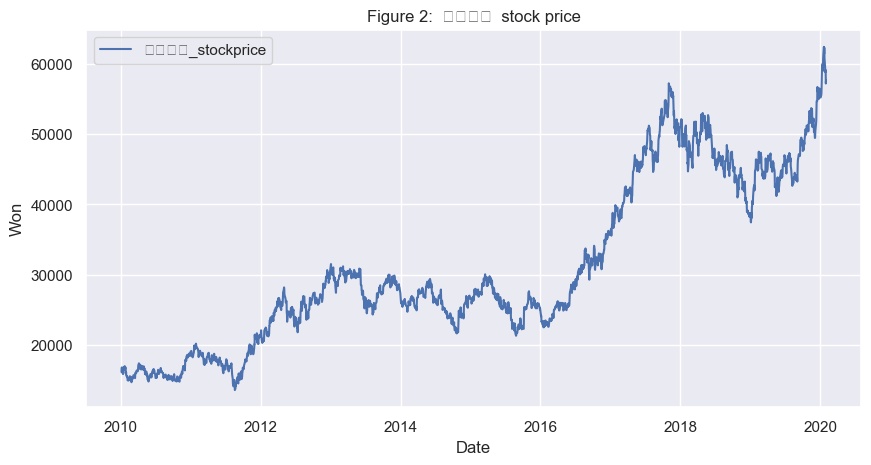


There are 2483 number of days in the dataset.



In [3]:
## load data
df = reader()

In [4]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
Date,,,,
2011-07-14,0.0,118000,NaN,NaN
2011-07-15,0.0,128000,NaN,NaN
2011-07-18,0.0,129000,NaN,NaN
2011-07-19,0.0,124000,NaN,NaN
2011-07-20,0.0,117500,NaN,NaN
...,...,...,...,...
2020-01-22,0.0,255000,330000.0,155000.0
2020-01-23,0.0,241000,330000.0,155000.0
2020-01-28,0.0,209000,330000.0,155000.0


In [5]:
count

211

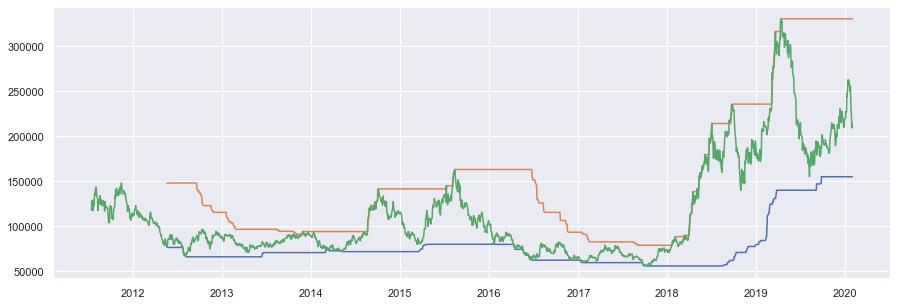

In [6]:
plt.figure(figsize = (15,5))
plt.plot(signals['RollingMin'])
plt.plot(signals['RollingMax'])
plt.plot(signals['trend'])

In [7]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000000,
    max_buy = 50,
    max_sell = 50,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f, current inventory %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money, current_inventory)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f, currnet inventory %f'
                    % (i, sell_units, total_sell, invest, initial_money, current_inventory)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, current_inventory

In [8]:
states_buy, states_sell, total_gains, invest,current_inventory = buy_stock(df.close, signals['signal'])

day 211: buy 50 units at price 3830000.000000, total balance 6170000.000000, current inventory 50.000000
day 255: buy 50 units at price 3765000.000000, total balance 2405000.000000, current inventory 100.000000
day 256: buy 33 units at price 2402400.000000, total balance 2600.000000, current inventory 133.000000
day 257: total balances 2600.000000, not enough money to buy a unit price 70400.000000
day 259: total balances 2600.000000, not enough money to buy a unit price 68200.000000
day 260: total balances 2600.000000, not enough money to buy a unit price 68000.000000
day 264: total balances 2600.000000, not enough money to buy a unit price 66200.000000
day 586, sell 50 units at price 4575000.000000, investment 38.217523 %, total balance 4577600.000000, currnet inventory 83.000000
day 587, sell 50 units at price 4630000.000000, investment 39.879154 %, total balance 9207600.000000, currnet inventory 33.000000
day 588, sell 33 units at price 3102000.000000, investment 41.993958 %, total 

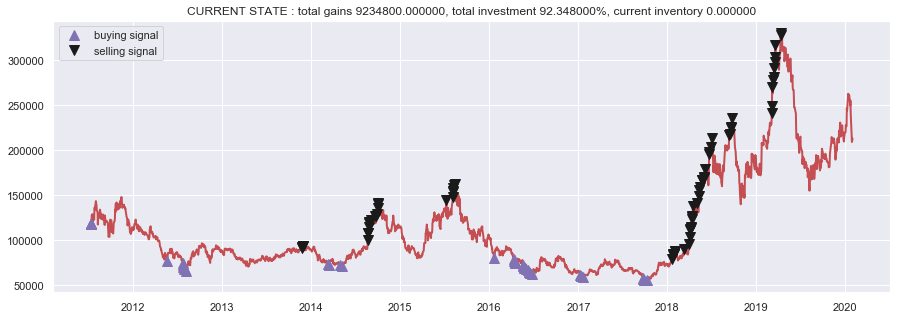

currnet profit(in value) :  9234800


In [9]:
close = df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('CURRENT STATE : total gains %f, total investment %f%%, current inventory %f'%(total_gains, invest, current_inventory))
plt.legend()
plt.show()

profit = (close[-1]*current_inventory)+total_gains
print("currnet profit(in value) : ", profit)